---

<center><h1>ADMN5015 Artificial Intelligence in Marketing</h1>
<h2>Assignment 3: Sentiment Analysis
<h3>Katrina Ong

---

**Summary**

This project aims to conduct a sentiment analysis on Twitter tweets using the Google Cloud Platform (GCP).

In particular, this notebook will be analyzing the most recent 100 tweets by the [Tim Hortons](https://twitter.com/TimHortons) (as of January 30, 11:38PM) as a means of evaluating the overall sentiment that they have been conveying through their social media presence in Twitter.

For this purpose, the following steps are implemented in this notebook: 
1. [Import Packages](#1\)-Import-Packages)
2. [Source the Data (using Twitter's API)](#2\)-Source-the-Data-(using-Twitter-API))
3. [Prepare the Data (Feature Engineering)](#3\)-Prepare-the-Data)
4. [Use GGP to conduct Sentiment Analysis](#4\)-Use-GCP-to-Conduct-Sentiment-Analysis)
5. [Summarize Sentiment Results](#5\)-Summarize-Sentiment-Results) - includes visualizations

More details can be found in each line of code below.

---

### 1) Import Packages

In [1]:
# Importing Standard packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import random
import os

In [2]:
# Set Options for display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.4f}'.format
sns.set_style("whitegrid")
#sns.set_context("paper", font_scale = 2)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None # default='warn'

In [3]:
# Importing packages for connecting to Twitter API
import requests
import json
import ast
import yaml

In [4]:
# Importing packages for data preparation
import re

In [5]:
# Importing NLP packages for Google Cloud
from google.cloud import language_v1

In [6]:
# Importing NLP package for text cleaning
import nltk
from nltk.corpus import stopwords

In [7]:
# Importing word cloud visualization package
from wordcloud import WordCloud 

---

### 2) Source the Data (using Twitter API)

In [8]:
# Defining a function to create a Twitter URL for a specific user based on their handle
def create_twitter_url(handle):
    max_results = 100
    mrf = "max_results={}".format(max_results)
    q = "query=from:{}".format(handle)
    url = "https://api.twitter.com/2/tweets/search/recent?{}&{}".format(
        mrf, q
    )
    return url

In [9]:
# Defining a function to open yaml file with credentials
def process_yaml():
    with open("config.yaml") as file:
        return yaml.safe_load(file)

In [10]:
# Defining a function to obtain the bearer token 
def create_bearer_token(data):
    return data["search_tweets_api"]["bearer_token"]

In [11]:
# Defining a function to obtain tweets using bearer token and Twitter URL
def twitter_auth_and_connect(bearer_token, url):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    response = requests.request("GET", url, headers=headers)
    return response.json()

In [12]:
# Defining a function to get tweets from a specific user based on their handle
def get_tweets(handle):
    url = create_twitter_url(handle)
    data = process_yaml()
    bearer_token = create_bearer_token(data)
    res_json = twitter_auth_and_connect(bearer_token, url)
    
    return res_json

In [13]:
# Define twitter handle to check
twitter_handle = "TimHortons"

In [14]:
# Create a dataframe using the json file containing tweets
df = pd.DataFrame.from_dict(get_tweets(twitter_handle)['data'])

In [15]:
# Preview Dataframe
df.head(3)

,edit_history_tweet_ids,id,text
0,[1620267932214231040],1620267932214231040,@jwindori 🥺 ❤️
1,[1620264491152801792],1620264491152801792,@aruun Yay! 🙌
2,[1620258259742474241],1620258259742474241,@MissBurbidge Yum! Which ones did you get? 😋


In [16]:
# Preview Dataframe
df.tail(3)

,edit_history_tweet_ids,id,text
97,[1619322799855734784],1619322799855734784,"@MiniKayTee Thank you for reaching out to us, ..."
98,[1619309935740715009],1619309935740715009,@LinG74394488 Thank you for reaching out to us...
99,[1619277519101870080],1619277519101870080,@valentino_nora Thanks for reaching out. We’re...


---

### 3) Prepare the Data

In [17]:
# Drop Irrelevant columns
df = df.drop('edit_history_tweet_ids', axis = 1)

In [18]:
#Preview Dataframe
df.head(3)

,id,text
0,1620267932214231040,@jwindori 🥺 ❤️
1,1620264491152801792,@aruun Yay! 🙌
2,1620258259742474241,@MissBurbidge Yum! Which ones did you get? 😋


In [19]:
# Check datatypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      100 non-null    object
 1   text    100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [20]:
# Convert data to string
df = df.astype('string')

In [21]:
# Check datatypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      100 non-null    string
 1   text    100 non-null    string
dtypes: string(2)
memory usage: 1.7 KB


In [22]:
# Remove usernames from tweets
df['text'] =  [re.sub('@[^\s]+','', str(x)) for x in df['text']]

In [23]:
# Remove links from tweets
df['text'] =  [re.sub('https[^\s]+','', str(x)) for x in df['text']]

In [24]:
# Preview Dataframe
df.head(3)

,id,text
0,1620267932214231040,🥺 ❤️
1,1620264491152801792,Yay! 🙌
2,1620258259742474241,Yum! Which ones did you get? 😋


---

### 4) Use GCP to Conduct Sentiment Analysis

#### 4a) Computing for Sentiment Scores and Magnitude

In [25]:
#Create environment variable for Google Cloud credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'admn5015-w2023-a01afcb67ba2.json' #"path/to/credentials.json"

In [26]:
# Instantiates a client
client = language_v1.LanguageServiceClient()

In [27]:
# Add columns to dataframe for sentiment_score and sentiment magnitude
df = df.reindex(columns=['id','text','sentiment_score','sentiment_magnitude'])

In [28]:
# Preview Dataframe
df.head(3)

,id,text,sentiment_score,sentiment_magnitude
0,1620267932214231040,🥺 ❤️,NaN,NaN
1,1620264491152801792,Yay! 🙌,NaN,NaN
2,1620258259742474241,Yum! Which ones did you get? 😋,NaN,NaN


In [29]:
# Loop through each record

for i in range(0,len(df)):
    
    #Create Document Object
    document = language_v1.Document(content=df['text'][i], type_=language_v1.Document.Type.PLAIN_TEXT)
    
    # Detects the sentiment of the text
    sentiment = client.analyze_sentiment(request={"document": document}).document_sentiment
    
    #Get Sentiment Score and Magnitude
    df.at[i,'sentiment_score'] = sentiment.score
    df.at[i,'sentiment_magnitude'] = sentiment.magnitude

In [30]:
# Preview Dataframe
df.head(3)

,id,text,sentiment_score,sentiment_magnitude
0,1620267932214231040,🥺 ❤️,0.6000,0.6000
1,1620264491152801792,Yay! 🙌,0.6000,1.2000
2,1620258259742474241,Yum! Which ones did you get? 😋,0.2000,0.8000


In [31]:
# Preview Dataframe
df.tail(3)

,id,text,sentiment_score,sentiment_magnitude
97,1619322799855734784,"Thank you for reaching out to us, our Digital...",0.4000,1.0000
98,1619309935740715009,"Thank you for reaching out to us, our Digital...",0.4000,1.0000
99,1619277519101870080,Thanks for reaching out. We’re sorry for any ...,0.4000,1.8000


In [32]:
# Check datatypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   100 non-null    string 
 1   text                 100 non-null    object 
 2   sentiment_score      100 non-null    float64
 3   sentiment_magnitude  100 non-null    float64
dtypes: float64(2), object(1), string(1)
memory usage: 3.2+ KB


In [33]:
# See descriptive statistics of sentiment scores
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment_score,100.0000,0.0890,0.4422,-0.6000,-0.2250,0.1500,0.4000,0.9000
sentiment_magnitude,100.0000,1.0100,0.3966,0.1000,0.8000,1.0000,1.1250,2.5000


#### 4b) Classifying Tweets into Sentiment Results

Tweets will be classified using the thresholds indicated in the table below. 

|Sentiment Class| Sentiment | Sentiment Score | Sentiment Magnitude |
|:-----:|:---------:|:---------------:|:--------------------:|
|1|Clearly Positive| Above 0 | Above 0 | 
|2|Clearly Negative| Below 0 | Above 0 |
|3|Neutral| Zero | Zero |
|4|Mixed | 0 | Above 0|

Tweets with a neutral score of 0 can show that a tweet has little or no emotions, or it could indicate mixed emotions that cancel each other out. 

This is why magnitude is taken into consideration since this indicates how much emotional content is in each tweet. More text in the document could generate more emotional content, which is why longer text could correspond to a higher sentiment magnitude. 

Considering that tweets are short text, a low threshold for sentiment magnitude is established.

Source: [Natural Language API Basics: Interpreting Sentiment Analysis Values](https://cloud.google.com/natural-language/docs/basics)

In [34]:
# Define conditions for sentiment classifications
condition_list = [(df['sentiment_score'].astype(float) > 0) & (df['sentiment_magnitude'].astype(float) > 0),
                  (df['sentiment_score'].astype(float) < 0) & (df['sentiment_magnitude'].astype(float) > 0),
                  (df['sentiment_score'].astype(float) == 0) & (df['sentiment_magnitude'].astype(float) < 0),
                  (df['sentiment_score'].astype(float) == 0) & (df['sentiment_magnitude'].astype(float) > 0)]

In [35]:
# Define Sentiment Classes
choice_list = ['Clearly Positive','Clearly Negative','Neutral','Mixed']

In [36]:
# Classify Tweets based on conditions
df['sentiment_class'] = np.select(condition_list, choice_list, "none")

In [37]:
# Preview the Dataframe
df.head(3)

,id,text,sentiment_score,sentiment_magnitude,sentiment_class
0,1620267932214231040,🥺 ❤️,0.6000,0.6000,Clearly Positive
1,1620264491152801792,Yay! 🙌,0.6000,1.2000,Clearly Positive
2,1620258259742474241,Yum! Which ones did you get? 😋,0.2000,0.8000,Clearly Positive


In [38]:
# Checking if all tweets have been classified (no 'none' values)
df['sentiment_class'].value_counts()

Clearly Positive    52
Clearly Negative    45
Mixed                3
Name: sentiment_class, dtype: int64

---

### 5) Summarize Sentiment Results

#### 5a) Sentiment Average

In [39]:
ave_sentiment = df['sentiment_score'].mean()

In [40]:
ave_magnitude = df['sentiment_magnitude'].mean()

In [41]:
print(f'''Average Sentiment Score: {round(ave_sentiment,2)}
Average Sentiment Magnitude: {round(ave_magnitude,2)}''')

Average Sentiment Score: 0.09
Average Sentiment Magnitude: 1.01


The average sentiment score, while positive, is quite close to zero. This could indicate a balanced number of positive and negative tweets that cancel each other out, or that most tweets are neutral. 

Additionally, the average sentiment is around 1, which is not surprising given the limited number of characters contained in a tweet. 

The following visualizations will add more depth to the interpretation of these numbers. 

#### 5b) Distribution of Sentiment Score and Sentiment Magnitude

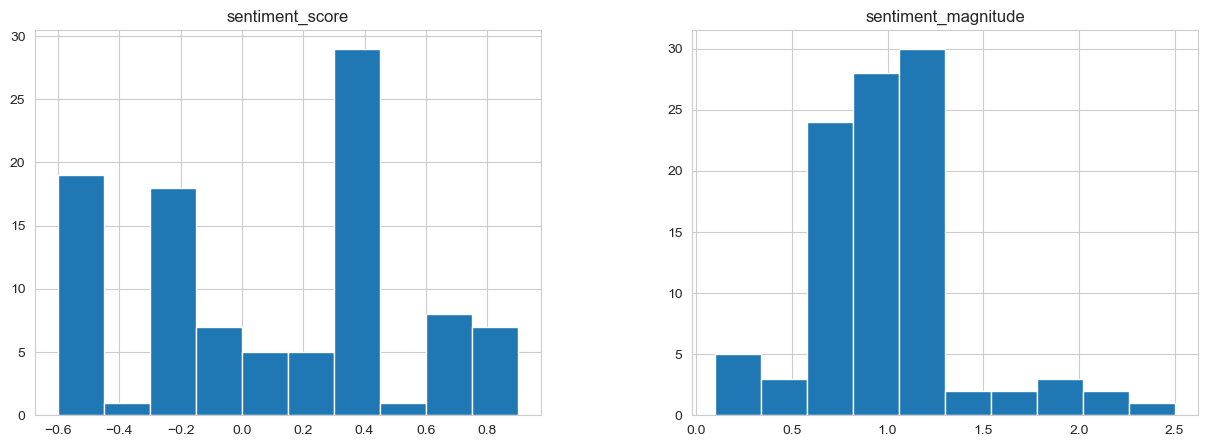

In [42]:
# Plot Distribution of Sentiment
df.hist(column = ['sentiment_score','sentiment_magnitude'],figsize=(15,5),bins = 10);

Taking the distribution of sentiment scores at face value, there seem to be more positive tweets than negative tweets.

Additionally, the sentiment magnitude distribution also seems to indicate that most tweets have some emotional content, although they are concentrated near the 1.0 value.

#### 5c) Count of Sentiment Classifications

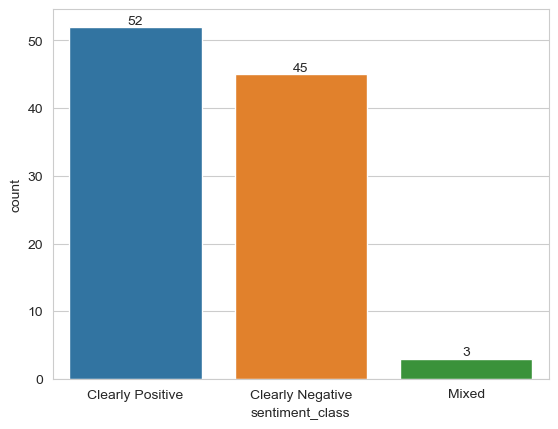

In [43]:
# Plot count of sentiment classifications
plt.rcParams['font.size'] = 10
ax = sns.countplot(data = df, x = "sentiment_class")
abs_values = df['sentiment_class'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values);

Based on the count of sentiment classifications, majority of tweets from Tim Hortons have been clearly positive, and the rest of the tweets are somewhat split between clearly negative and mixed sentiments. This could indicate the Tim Hortons' social media management is able to convey positive emotions for its brand.

A deeper analysis may be recommended for clearly negative tweets to determine why negative emotions are being conveyed in these tweets. 

Further sentiment analysis can also be conducted based on tweets from other accounts that mention the brand, or from the brand's competitors. 

#### 5d) Word Clouds of Tweets

##### Positive Tweets

In [44]:
# Defining insignificant words with little meaning/ value
stop_words = stopwords.words('english')

In [45]:
# Creating a positive tweets dataframe
df_positive = df[df['sentiment_class']== 'Clearly Positive']

In [46]:
# Instantiating a Word Cloud object for positive tweets
pos_tweets = WordCloud(stopwords = stop_words, background_color="white").generate(' '.join(df_positive['text']))

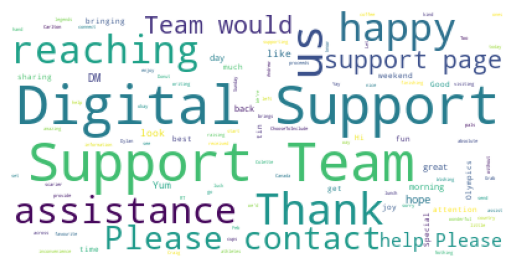

In [47]:
# Visualize Word Cloud
plt.imshow(pos_tweets)
plt.axis("off")
plt.show()

##### Negative Tweets

In [48]:
# Creating a negative tweets dataframe
df_negative = df[df['sentiment_class']== 'Clearly Negative']

In [49]:
# Instantiating a Word Cloud object for negative tweets
neg_tweets = WordCloud(stopwords = stop_words, background_color="white").generate(' '.join(df_negative['text']))

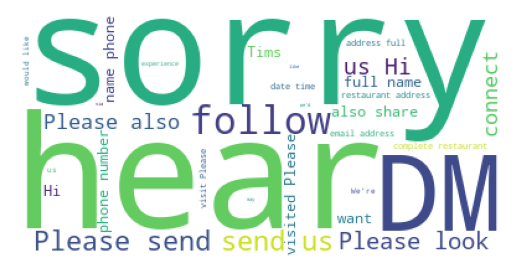

In [50]:
# Visualize Word Cloud
plt.imshow(neg_tweets)
plt.axis("off")
plt.show()

##### World Cloud Interpretations

It seems that most tweets, both positive and negative, have a notable number of imperative words and word combinations like "please", "please follow", "please send", "please contact", etc. 

Positive words like "support" and "thank", "happy", "assistance, and "support team" seem to be highly observed in positive tweets. On the other hand, "sorry" seems to be a highly common word among negative tweets, which indicate that it could be replies to customer complaints. One caveat is that these word clouds do not show emoticons used in tweets, which could contribute to the sentiment score generated through GCP which detects such characters.

Determining the root cause of these tweets could provide more insight as to how Tim Hortons could further improve customer experience as well as take care of their brand reputation.